<a href="https://colab.research.google.com/github/pawanraje16/CVDLlab/blob/main/VisionTranformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


In [6]:

import zipfile

with zipfile.ZipFile("mango-leaf-disease-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir="/content/data"

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [ ]:
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Sooty Mould"]


In [ ]:
images = []
labels = []


Loading and preprocessing dataset...
Loading Anthracnose images...
Loading Bacterial Canker images...
Loading Cutting Weevil images...
Loading Die Back images...
Loading Gall Midge images...
Loading Healthy images...
Loading Sooty Mould images...
Dataset loaded: 3500 images
Image shape: (224, 224, 3)
Training set: 2800 images
Validation set: 700 images


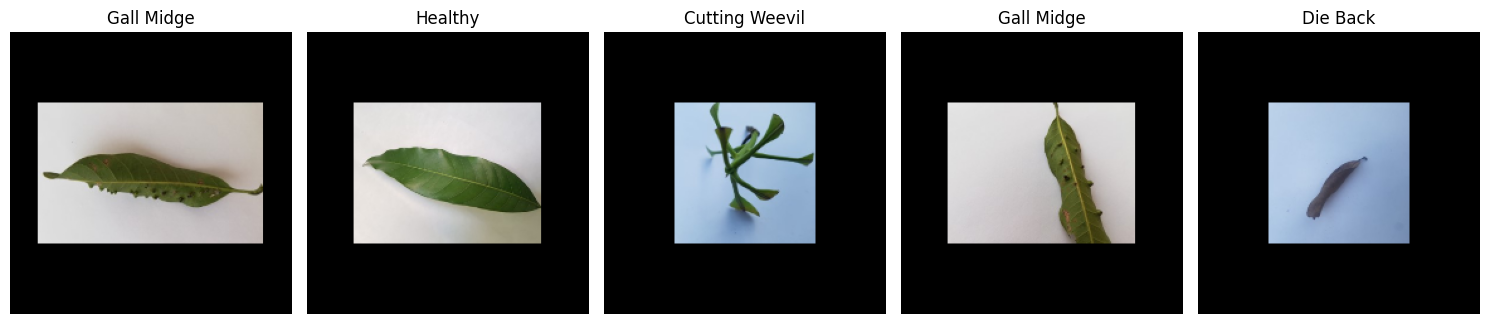

Preprocessing completed and data split into training and validation sets.


In [ ]:
# Process each class folder
print("Loading and preprocessing dataset...")
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    print(f"Loading {class_name} images...")

    # Get image files in the class directory
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image in the folder
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)

        # Load image
        img = load_img(image_path)
        img_array = img_to_array(img)

        # Get original dimensions
        height, width, channels = img_array.shape

        # Calculate aspect ratio
        aspect_ratio = width / height

        # Resize while preserving aspect ratio to 224x112
        if aspect_ratio > 2:  # width > 2*height
            new_width = 224
            new_height = int(new_width / aspect_ratio)
            if new_height > 112:
                new_height = 112
                new_width = int(new_height * aspect_ratio)
        else:  # height >= width/2
            new_height = 112
            new_width = int(new_height * aspect_ratio)
            if new_width > 224:
                new_width = 224
                new_height = int(new_width / aspect_ratio)

        # Resize the image
        resized_img = tf.image.resize(img_array, [new_height, new_width])

        # Create a blank 224x224 image
        padded_img = np.zeros((224, 224, 3), dtype=np.float32)

        # Calculate padding
        pad_height = (224 - new_height) // 2
        pad_width = (224 - new_width) // 2

        # Place the resized image in the center
        padded_img[pad_height:pad_height+new_height, pad_width:pad_width+new_width, :] = resized_img

        # Normalize with mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        normalized_img = (padded_img / 255.0 - 0.5) / 0.5

        # Add to dataset
        images.append(normalized_img)
        labels.append(class_idx)

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# One-hot encode the labels
y_onehot = to_categorical(y, num_classes=len(class_names))

# Split the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)

# Print dataset information
print(f"Dataset loaded: {X.shape[0]} images")
print(f"Image shape: {X.shape[1:]}")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")

# Visualize some preprocessed images
plt.figure(figsize=(15, 10))
num_samples = 5
y_indices = np.argmax(y_train[:num_samples], axis=1)

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)

    # Denormalize the image for visualization
    img = X_train[i] * 0.5 + 0.5
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(class_names[y_indices[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save preprocessed data
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

print("Preprocessing completed and data split into training and validation sets.")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import timm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load preprocessed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

# Number of classes in the mango leaf dataset
num_classes = 7  # Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Healthy, Sooty Mould

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).permute(0, 3, 1, 2).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create PyTorch datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load pre-trained Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the classification head to match the number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

# Move model to device (GPU if available)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            _, labels_idx = torch.max(labels, 1)
            correct += (predicted == labels_idx).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'mango_disease_vit_model.pth')
print("Training completed and model saved.")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5
Training Loss: 0.2700
Validation Loss: 0.0561, Accuracy: 0.9800
Epoch 2/5
Training Loss: 0.0314
Validation Loss: 0.0360, Accuracy: 0.9886
Epoch 3/5
Training Loss: 0.0628
Validation Loss: 0.2063, Accuracy: 0.9371
Epoch 4/5
Training Loss: 0.0651
Validation Loss: 0.0474, Accuracy: 0.9857
Epoch 5/5
Training Loss: 0.0131
Validation Loss: 0.0534, Accuracy: 0.9786
Training completed and model saved.


Using device: cuda
Validation Accuracy: 0.9786


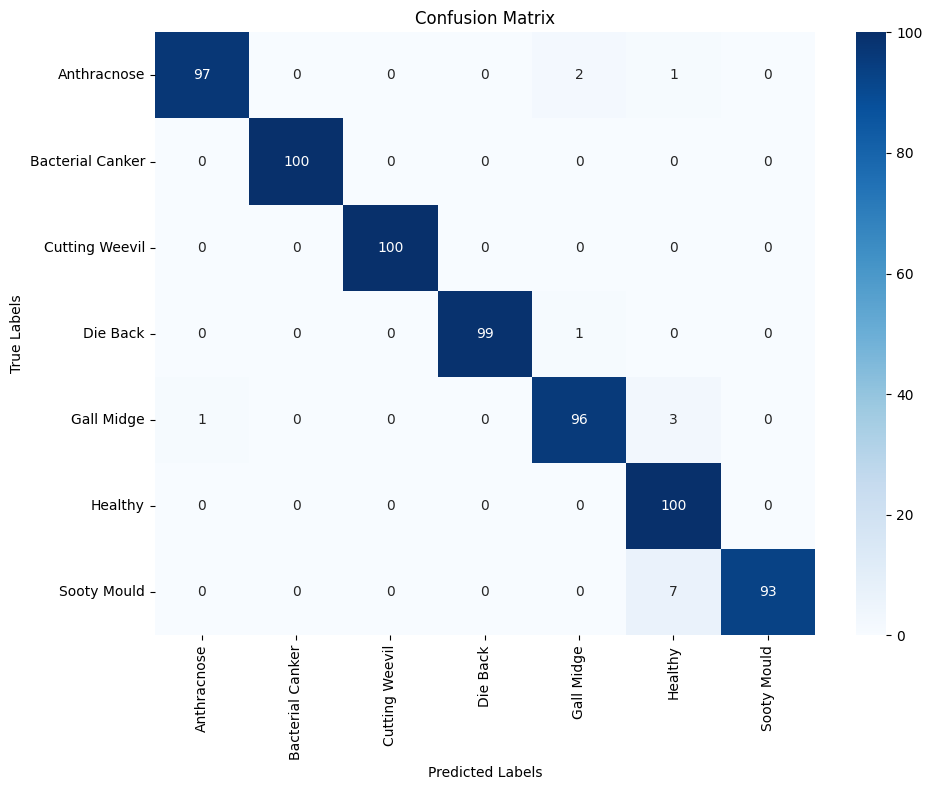

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.99      0.97      0.98       100
Bacterial Canker       1.00      1.00      1.00       100
  Cutting Weevil       1.00      1.00      1.00       100
        Die Back       1.00      0.99      0.99       100
      Gall Midge       0.97      0.96      0.96       100
         Healthy       0.90      1.00      0.95       100
     Sooty Mould       1.00      0.93      0.96       100

        accuracy                           0.98       700
       macro avg       0.98      0.98      0.98       700
    weighted avg       0.98      0.98      0.98       700



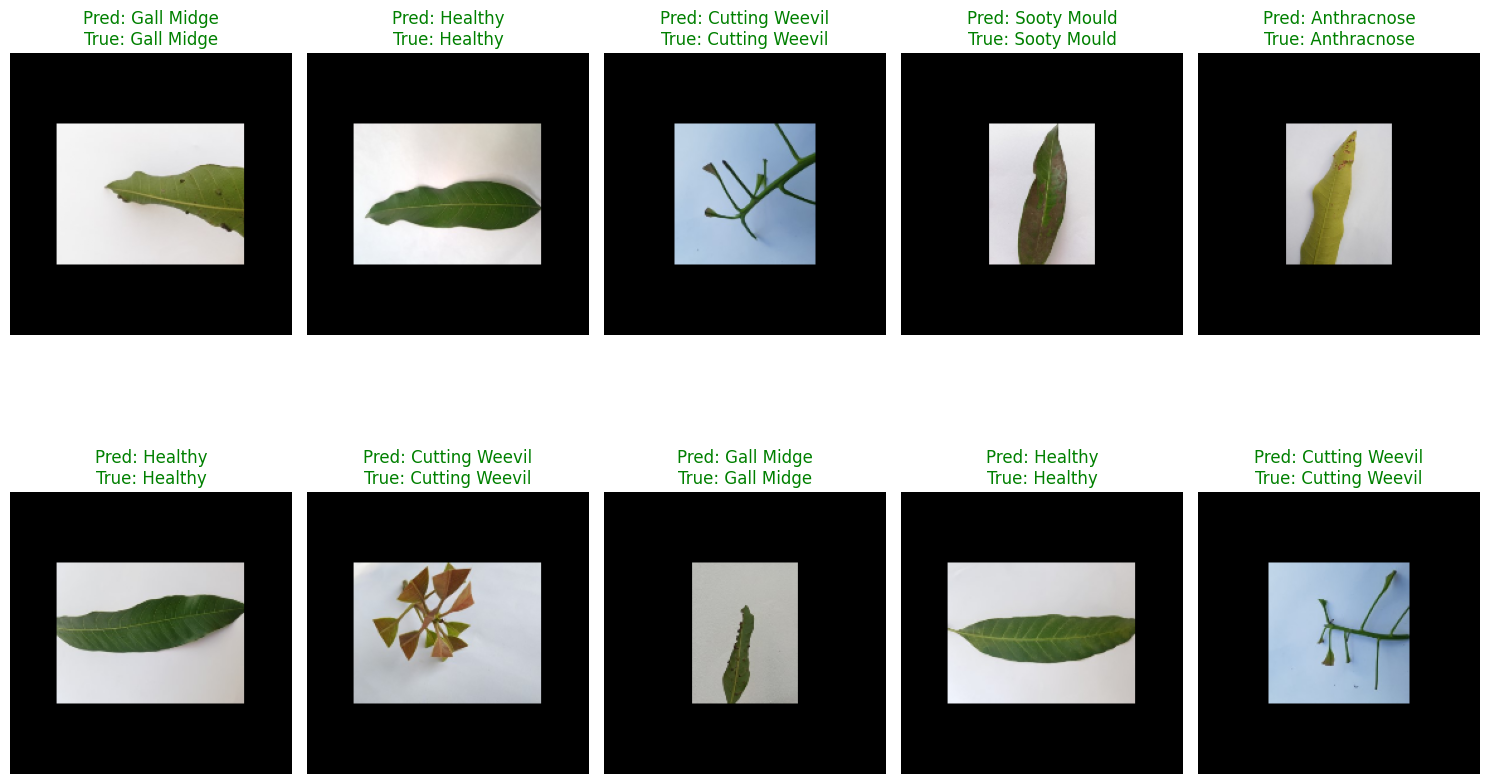

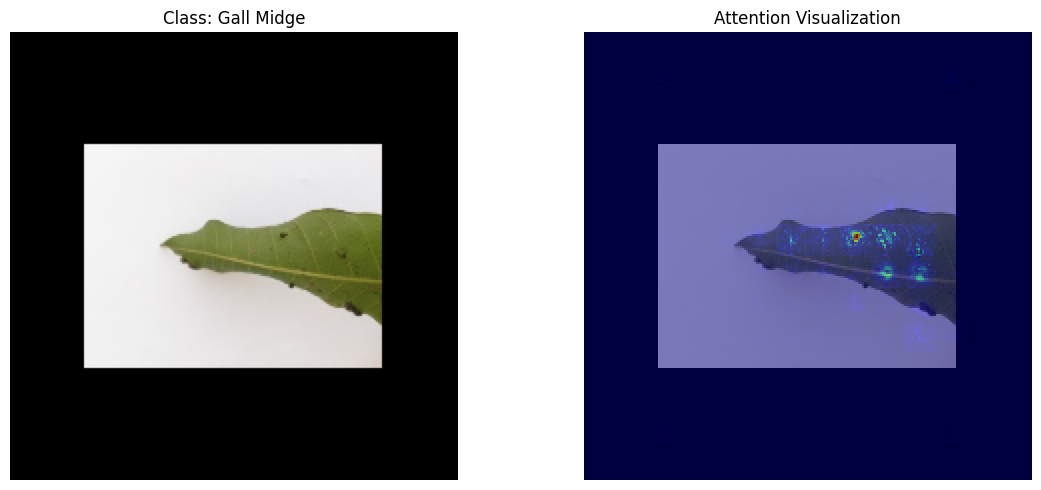

Areas with high attention (red/yellow) are regions the model focused on when classifying this Gall Midge image.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import timm
import torch.nn as nn

# Class names
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Sooty Mould"]

# Load preprocessed data
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

# Convert validation data to PyTorch tensors
X_val_tensor = torch.from_numpy(X_val).permute(0, 3, 1, 2).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Recreate the model architecture
num_classes = len(class_names)
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load('mango_disease_vit_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Make predictions
all_preds = []
all_probs = []
batch_size = 32

with torch.no_grad():
    for i in range(0, len(X_val_tensor), batch_size):
        batch = X_val_tensor[i:i+batch_size].to(device)
        outputs = model(batch)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
y_pred = np.array(all_preds)
y_pred_probs = np.array(all_probs)
y_true = np.argmax(y_val, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Validation Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Display 10 validation images with their predictions
plt.figure(figsize=(15, 10))
for i in range(10):
    # Get a sample image
    img = X_val[i]
    true_label = class_names[np.argmax(y_val[i])]
    pred_label = class_names[y_pred[i]]

    # Denormalize the image
    img = img * 0.5 + 0.5  # Reverse normalization
    img = np.clip(img, 0, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
              color="green" if pred_label == true_label else "red")
    plt.axis('off')
plt.tight_layout()
plt.savefig('prediction_examples.png')
plt.show()

# Attention visualization - Get a correctly classified image
# Attention visualization - Get a correctly classified image
correct_indices = np.where(y_pred == y_true)[0]
if len(correct_indices) > 0:
    correct_idx = correct_indices[0]
    sample_img = X_val_tensor[correct_idx:correct_idx+1].to(device)

    # Alternative approach for attention visualization using gradients (Grad-CAM like)
    # This works even if we can't directly access attention weights

    # Enable gradients for this part
    sample_img.requires_grad_()

    # Forward pass
    outputs = model(sample_img)
    score = outputs[0, y_true[correct_idx]]

    # Backward pass to get gradients
    score.backward()

    # Get gradients from the last layer (before classification head)
    # For vit_base_patch16_224, we can get the patch embeddings
    gradients = sample_img.grad.detach()

    # Take absolute value and average across channels
    attention_map = torch.mean(torch.abs(gradients), dim=1).squeeze().cpu().numpy()

    # Reshape to match image dimensions
    attention_map = attention_map.reshape(224, 224)

    # Normalize for visualization
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

    # Display the image and attention map
    plt.figure(figsize=(12, 5))

    # Original image
    plt.subplot(1, 2, 1)
    img_to_show = X_val[correct_idx] * 0.5 + 0.5
    img_to_show = np.clip(img_to_show, 0, 1)
    plt.imshow(img_to_show)
    plt.title(f"Class: {class_names[y_true[correct_idx]]}")
    plt.axis('off')

    # Attention map
    plt.subplot(1, 2, 2)
    plt.imshow(img_to_show)
    plt.imshow(attention_map, cmap='jet', alpha=0.5)
    plt.title("Attention Visualization")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('attention_visualization.png')
    plt.show()

    print(f"Areas with high attention (red/yellow) are regions the model focused on when classifying this {class_names[y_true[correct_idx]]} image.")
else:
    print("No correctly classified images found in the first few samples.")